In [1]:
import sys, os
import pandas as pd
import numpy as np
import os
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import model_from_json
from keras.utils import np_utils
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/mainak09/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mainak09/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mainak09/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mainak09/anaconda3/lib/python3.7/site-packag

In [ ]:
df=pd.read_csv('fer2013.csv')

print(df.info())
print(df["Usage"].value_counts())

print(df.head())

In [ ]:
mkdir fer_images

In [ ]:
fer_data=pd.read_csv('./fer2013.csv',delimiter=',')
def save_fer_img():
    print("Please wait...")

    for index,row in fer_data.iterrows():
        pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
        img=pixels.reshape((48,48))
        pathname=os.path.join('fer_images',str(index)+'.jpg')
        cv2.imwrite(pathname,img)
    print("Done")
    
save_fer_img()    

In [ ]:
save_fer_img() 

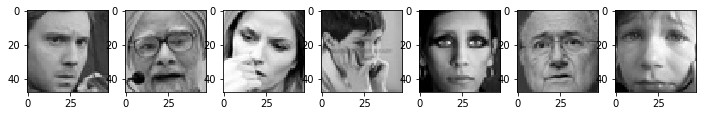

In [7]:
fig, axs = plt.subplots(1, 7, figsize=(12,2))
for i in range(7):
    path = './fer_images/'+str(i)+'.jpg'
    img2 = cv2.imread(path)
    axs[i].imshow(img2)

In [3]:
X_train,train_y,X_test,test_y=[],[],[],[]

for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")


num_features = 64
num_labels = 7
batch_size = 64
epochs = 30
width, height = 48, 48


X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)

#cannot produce
#normalizing data between oand 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

# print(f"shape:{X_train.shape}")
##designing the cnn
#1st convolution layer
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:]), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

In [4]:
#Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
#Training the model
model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True)

In [ ]:
#Saving the  model to  use it later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

In [19]:
#load model
model = model_from_json(open("./model/fer.json", "r").read())
#load weights
model.load_weights('./model/fer.h5')
face_haar_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)      

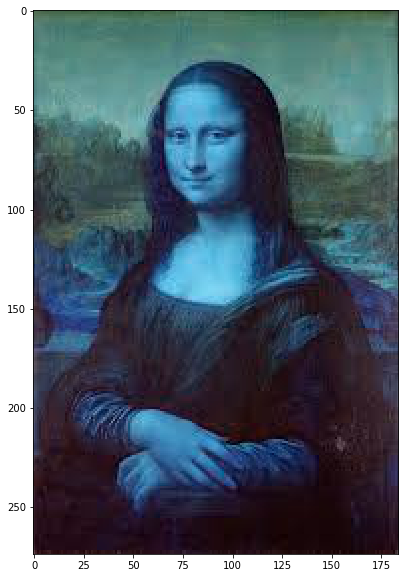

In [21]:
IMG_SIZE=100
#open image here
path = './Mona_lisa.jpg'
test_img2 = cv2.imread(path)
plt.figure(figsize = (20,10))
plt.axis('on')
plt.imshow(test_img2)

In [22]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
gray_img= cv2.cvtColor(test_img2, cv2.COLOR_BGR2GRAY)
faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)

for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img2,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255
        
        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img2, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        resized_img = cv2.resize(test_img2, (1000, 700))

        filename = 'savedImage.jpg'
        cv2.imwrite(filename, test_img2) 
        
        #open savedImage.jpg


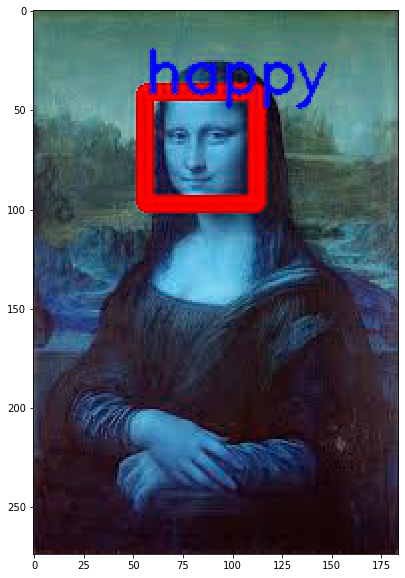

In [23]:
path = './savedImage.jpg'
test_img2 = cv2.imread(path)

plt.figure(figsize = (20,10))
plt.axis('on')
plt.imshow(test_img2)

***
## Basic Webcam Video Stream (BW):

In [ ]:
# do not touch, no

import cv2, time
video = cv2.VideoCapture(0)
a=0

while True:
    a=a+1
    
    check, frame = video.read()
    #print(check)
    #print(frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow("Capturing", gray)
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
        
print(a)
video.release()
cv2.destroyAllWindows()

# press Q to stop

***
## Color Webcam stream:

In [1]:
# color webcam stream, somehow works
import cv2 

key = cv2. waitKey(1)
webcam = cv2.VideoCapture(0)
while True:
    try:
        check, frame = webcam.read()
        #print(check) #prints true as long as the webcam is running
        #print(frame) #prints matrix values of each framecd 
        cv2.imshow("Capturing", frame)
        filename = 'saved_Image.jpg'
        cv2.imwrite(filename, frame) 
        
        
        
        
        key = cv2.waitKey(1)
        
        
    except(KeyboardInterrupt):
        print("Turning off camera.....")
        webcam.release()
        print("Camera off.")
        print("Program Terminated")
        cv2.destroyAllWindows()
        break
        
        
        

Turning off camera.....
Camera off.
Program Terminated


***
## Running the trained model

* Runs pretty well on well lit conditions.
* Press q to stop.

In [ ]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

#load model
model = model_from_json(open("fer.json", "r").read())
#load weights
model.load_weights('fer.h5')


face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


cap=cv2.VideoCapture(0)

while True:
    
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        predicted_emotion = emotions[max_index]

        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (700, 500))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):
        #wait until 'q' key is pressed
        
        
        cv2.destroyAllWindows
        break

cap.release()


## To Do:
* Show corresponding Emoji.
* Attempt to increase model accuracy.
* Attempt to augment training data.